In [1]:
#libraries 
import numpy as np
import matplotlib.pyplot as plt
import mne

from Data_extractions import  extract_data_from_subject
from Data_processing import filter_by_condition, filter_by_class


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from scipy.signal import filtfilt, firwin
from scipy.signal import welch
from scipy.integrate import simps


import joblib 


some notes on the dataset folder: 
- composed of 10 subfolders each one corresponding to a different person
- there is an additional folder, containing five files obtained after the proposed processing: EEG data, Baseline data, External electrodes data, Events data and a Report file

raw data
- eeg data: sampling frequency 256Hz; 128 channels 

notes
- classes: "arriba", "abajo", "derecha", "izquierda"
- per trial: 

    t[0, 0.5]s = white dot on screen; fixed gaze

    t[0.5, 1]s = triangle with a certain direction appears on screen

    t[1, 3.5]s = action interval 
    
    t>3.5s = relax interval 

![image.png](attachment:image.png)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
(500, 87, 1153)
(200, 87, 640)
(200,)


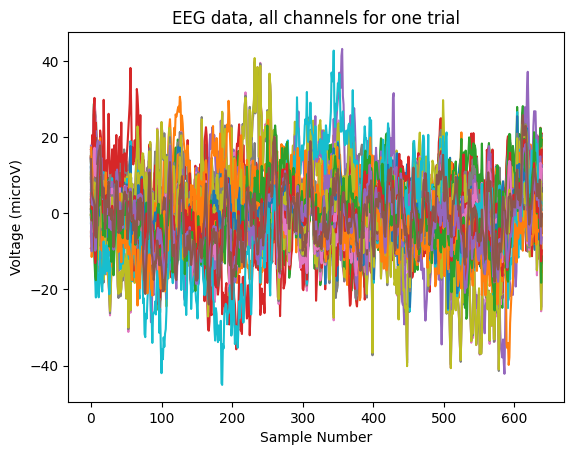

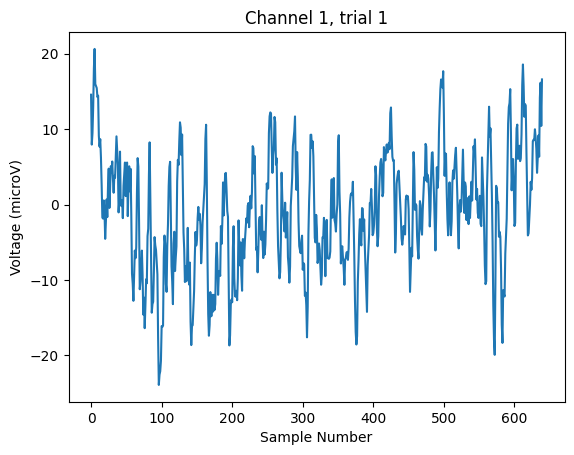

In [2]:

#loading dataset 
#change directory as necessary 
directory = 'C:/Users/serpr/OneDrive - Universidade do Porto/Documentos/4ºano_2ºsemestre/robotica/projeto/inner-speech-recognition'

#enter the number of the subject (1 to 10)
subject = 1
datatype ='eeg'

# selected channels 
#from frontal right and left or just frontal left
selected_channels =['A1', 'A2', 'A3', 'A4', 'A19', 'A23', 'B1', 'B2', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 
                    'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 
                    'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'D1', 'D2', 
                    'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23',
                    'D24', 'D25', 'D26', 'D27', 'D28']

#left hemisphere
# selected_channels = ['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18',
#                      'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32',
#                      'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19',
#                      'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32'] 


X, Y = extract_data_from_subject(directory, subject, datatype, selected_channels)
# returns the 3 sessions concerning subject 
print(X.shape)


#selecting time window
t_start = 1
t_end = 3.5
fs = 256

t_max = X.shape[2]
start = max(round(t_start * fs), 0)
end = min(round(t_end * fs), t_max)

X_window = X[:, :, start:end]

#selecting data from inner speech/ visualized/ pronounced
#type: "inner, visualized or pronounced"
condition = "inner"
classe = "all"
X_filt, Y_filt = filter_by_condition(X_window, Y, condition)
X_filt, Y_filt = filter_by_class(X_filt,Y_filt,classe)

#Convert to microvolts 
X_resize = X_filt * (10**6)
print(X_resize.shape)

#Identification of the direction of the trial, given in the second column of the labels. 
data_labels= Y_filt[:,1]

#translating the integer labels
trials_dict = {0:'up', 1:'down', 2:'right', 3:'left'}
trial_labels = np.array([trials_dict[direction] for direction in data_labels])
print(trial_labels.shape)

for i in range(X_resize.shape[1]-1):
    plt.plot(X_resize[0,i,:])
end

plt.title('EEG data, all channels for one trial')
plt.ylabel('Voltage (microV)')
plt.xlabel('Sample Number')
plt.show()

# Plot of a specific trial and channel
# Choose the trial index (0 to 199) 
# Choose the channel index (0 to 86) if frontal and parietal channels are selected
trial_index = 0  
selected_channel_index = 0  

plt.plot(X_resize[0, selected_channel_index, :])
plt.title('Channel '+ str(selected_channel_index + 1) + ', trial ' + str(trial_index+1))
plt.ylabel('Voltage (microV)')
plt.xlabel('Sample Number')
plt.show()

**Brain waves**

*delta waves* - 0.1 : 4Hz - deep (dreamless), sleep, loss of bodily awareness, repair

*theta waves* - 4 : 8Hz - creativity, insight, deep states, dreams, deep meditation, reduced consciousness

*alfa waves* - 8 : 13Hz - physically and mentally relaxed

*beta waves* - 14 : 30Hz - awake, alert consciousness, thinking, excitement  

*gamma waves* - >30 : 80Hz - heightened perception, learning, problem solving tasks 

**FIR Filter**

Our waves of interest are the alfa, beta and lower gamma waves


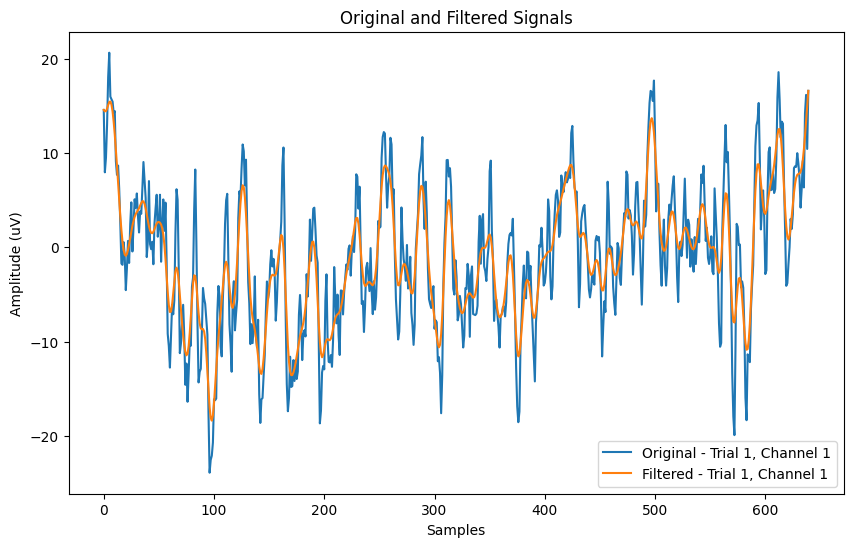

In [5]:
def fir_bandpass_filter(X, fs, lowcut, highcut, filter_order):
    # normalized cut-off frequencies
    nyquist_freq = 0.5 * fs
    lowcut_normalized = lowcut / nyquist_freq
    highcut_normalized = highcut / nyquist_freq

    # filter design
    lowpass_filter = firwin(filter_order, highcut_normalized, pass_zero=True, window = 'hamming')
    highpass_filter = firwin(filter_order, lowcut_normalized, pass_zero=True, window = 'hamming')

    # applying lowpass filter
    X_lowpass = filtfilt(lowpass_filter, 1, X, axis=-1)
    
    # applying highpass filter
    X_highpass = filtfilt(highpass_filter, 1, X_lowpass, axis=-1)

    return X_highpass

# cut-off frequencies
lowcut = 1
highcut = 100

# defining filter order 
filter_order = 10

# applying the filter to the signal 
X_windowed = fir_bandpass_filter(X_resize, fs, lowcut, highcut, filter_order)

plt.figure(figsize=(10, 6))
plt.plot(X_resize[trial_index, selected_channel_index, :], label=f'Original - Trial {trial_index+1}, Channel {selected_channel_index+1}')
plt.plot(X_windowed[trial_index, selected_channel_index, :], label=f'Filtered - Trial {trial_index+1}, Channel {selected_channel_index+1}')
plt.xlabel('Samples')
plt.ylabel('Amplitude (uV)')
plt.title('Original and Filtered Signals')
plt.legend()
plt.show()


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Data size of subject 1, session 1: (1, 87, 3841)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Data size of subject 1, session 2: (1, 87, 3841)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Data size of subject 1, session 3: (1, 87, 3841)
(3, 1, 87, 3841)
X_window_corrected shape: (200, 87, 640)
X_window_b shape: (200, 87, 3840)
X_window_inicial shape: (200, 87, 640)


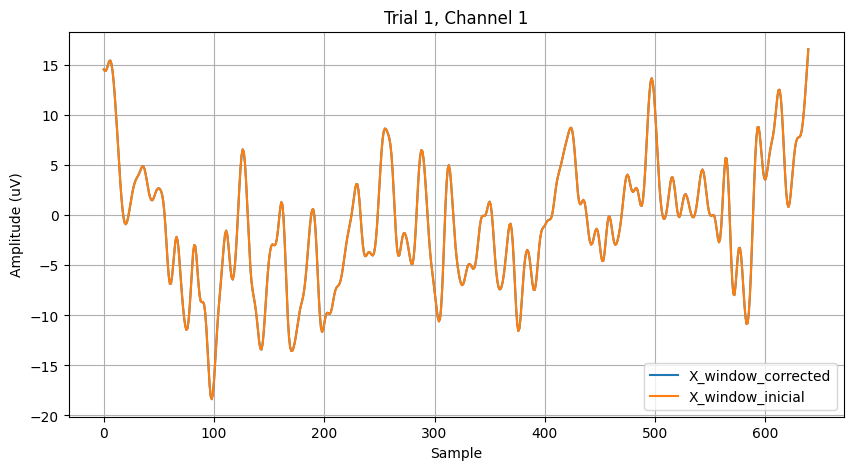

In [6]:
#extracting baselines from individuals for 3 sessions 
def extract_baseline_epoch(n_s, selected_channels):
    # directory - change as necessary 
    root_dir = r"C:\Users\serpr\OneDrive - Universidade do Porto\Documentos\4ºano_2ºsemestre\robotica\projeto\inner-speech-recognition\derivatives\sub-"

    baseline_data=[]
    for n_session in [1, 2, 3]:
        # full path
        file_name = f"{root_dir}{n_s:02d}\ses-0{n_session}\sub-{n_s:02d}_ses-0{n_session}_baseline-epo.fif"
        # loads data 
        baseline_epochs = mne.read_epochs(file_name, verbose='WARNING')
        # selects desired channels
        baseline_epochs.pick_channels(selected_channels)
        baseline = baseline_epochs._data
        baseline_data.append(baseline)
        print(f"Data size of subject {n_s}, session {n_session}: {baseline.shape}")

    baseline_data = np.array(baseline_data)
    print(baseline_data.shape)
    return(baseline_data)

x1_baseline = extract_baseline_epoch(1, selected_channels)
average_baseline = np.mean(x1_baseline, axis=0)
average_baseline = average_baseline * (10**6)
baseline_filtered = fir_bandpass_filter(average_baseline, fs, lowcut, highcut, filter_order)
t_start_baseline =0
t_end_baseline = 15
t_max = baseline_filtered.shape[2]

start_b = max(round(t_start_baseline * fs), 0)
end_b = min(round(t_end_baseline * fs), t_max)
X_baseline_1 = baseline_filtered[:, :, start_b:end_b]
X_baseline_tiled = np.tile(X_baseline_1, (X_resize.shape[0], 1, 1))  # Shape: (50, 87, 51)

def baseline_removal(X_window_b, X_window, trial_idx, channel_idx):
    #Verify input data dimensions
    num_trials, num_channels, num_samples = X_window.shape
    num_trials_b, num_channels_b, num_samples_b = X_window_b.shape

    # Check if the number of trials and channels are consistent between X_window and X_window_b
    assert num_trials == num_trials_b, "Mismatch in number of trials between X_window and X_window_b"
    assert num_channels == num_channels_b, "Mismatch in number of channels between X_window and X_window_b"

    # Average signal for each channel and each trial in X_window_b
    average_signal = np.mean(X_window_b, axis=2)  

    # Initialize array to store corrected data
    X_window_corrected = np.zeros_like(X_window)  

    for i in range(num_trials):
        for j in range(num_channels):
            # Subtract the average signal from the current trial and channel
            X_window_corrected[i, j, :] = X_window[i, j, :] - average_signal[i, j]

    print("X_window_corrected shape:", X_window_corrected.shape)
    print("X_window_b shape:", X_window_b.shape)
    print("X_window_inicial shape:", X_window.shape)

    # Get the data for the chosen trial and channel
    data_window = X_window_corrected[trial_idx, channel_idx, :]
    data_window_inicial = X_window[trial_idx, channel_idx, :]

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(data_window, label='X_window_corrected')
    plt.plot(data_window_inicial, label='X_window_inicial')
    plt.title(f'Trial {trial_idx + 1}, Channel {channel_idx + 1}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude (uV)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return X_window_corrected


X_windowed = baseline_removal(X_baseline_tiled, X_windowed, trial_index, selected_channel_index)


In [32]:

# Function plot  fft/Welch/multitaper for a specific channel
def plot_periodogram(method, trial_index, channel_index, f, Pxx):
    plt.figure()
    plt.plot(f, Pxx[trial_index, channel_index, :])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (uV/Hz)')
    if (method == 'Welch'):
        plt.title('Welch Periodogram - Channel {}'.format(channel_index + 1)+ ', trial -' + str(trial_index+1))
    
    plt.show()

def plot_periodogram_bluearea(f,P,idx, channel_index, trial_index,method ):
# Plot of the power spectral density 
    plt.figure(figsize=(7, 4))
    plt.plot(f, P, lw=1, color='k')
    plt.fill_between(f, P, where=idx, color='lightblue')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (uV/Hz)')
    if (method == 'Welch'):
        plt.title('Welch Periodogram - Channel {}'.format(channel_index + 1)+ ', trial -' + str(trial_index+1))
   
    plt.show()


**Feature selection**

The absolute power, conserning the desired frequecy range, is equal to the blue area. The area was determined using the composite Simpson's rule. 
https://raphaelvallat.com/bandpower.html

In [34]:
 
def compute_absolute_power(data, idx, f_res):
    """
    Compute the absolute power for each trial and channel for the desired range of frequencies

    Parameters:
    - Pxx: 3D NumPy array of shape (num_trials, num_channels, num_freq_bins)

    - idx: Boolean array indicating the frequency range for delta band.
    - f_res: Frequency resolution.

    Returns:
    - absolute_delta_power: 1D NumPy array containing the absolute delta power
                            for each trial and channel.
    """
    num_trials = data.shape[0]
    num_channels = data.shape[1]
    absolute_power = np.zeros((num_trials, num_channels))

    # Iterate over each trial
    for trial_index in range(num_trials):
        # Iterate over each channel
        for channel_index in range(num_channels):
            # Compute the absolute delta power for the current trial and channel
            power = simps(data[trial_index, channel_index, idx], dx=f_res)
            # Append the result to the list
            absolute_power[trial_index, channel_index] = power

    return absolute_power

In [35]:
def compute_alpha_beta_ratio(data, alpha_idx, beta_idx, f_res):
    """
    Compute the ratio between alpha and beta waves for each trial and channel.

    Parameters:
    - data: 3D NumPy array of shape (num_trials, num_channels, num_freq_bins)
    - alpha_idx: Boolean array indicating the frequency range for alpha band.
    - beta_idx: Boolean array indicating the frequency range for beta band.
    - f_res: Frequency resolution.

    Returns:
    - alpha_beta_ratio: 2D NumPy array containing the ratio between alpha and beta waves
                        for each trial and channel.
    """
    # Compute absolute power for alpha and beta bands
    alpha_power = compute_absolute_power(data, alpha_idx, f_res)
    beta_power = compute_absolute_power(data, beta_idx, f_res)

    # Compute the ratio between alpha and beta waves
    alpha_beta_ratio = alpha_power / beta_power

    return alpha_beta_ratio

In [36]:
def compute_alpha_delta_ratio(data, alpha_idx, delta_idx, f_res):
    # Compute absolute power for alpha and beta bands
    alpha_power = compute_absolute_power(data, alpha_idx, f_res)
    delta_power = compute_absolute_power(data, delta_idx, f_res)

    # Compute the ratio between alpha and beta waves
    alpha_beta_ratio_delta = alpha_power/delta_power

    return alpha_beta_ratio_delta

In [37]:
def compute_beta_delta_ratio(data, beta_idx, delta_idx, f_res):
    # Compute absolute power for alpha and beta bands
    beta_power = compute_absolute_power(data, beta_idx, f_res)
    delta_power = compute_absolute_power(data, delta_idx, f_res)

    # Compute the ratio between alpha and beta waves
    alpha_beta_ratio_delta = beta_power/delta_power

    return alpha_beta_ratio_delta

In [38]:
def compute_mean(data, idx):
    #computes mean for a desired frequency band
    return np.mean(data[:, :, idx], axis=-1)


def compute_variance(data, idx):
    #computes variance within a certain frequency band
    return np.var(data[:, :, idx], axis=-1)


In [39]:
#Defining lower and upper limits
low, high = 8, 40
alpha_band = (8, 13)
beta_band = (13, 30)
delta_band = (30,60)

**Feature extraction**

*Welch's peridiogram*:

It consists in averaging consecutive Fourier transform of small windows of the signal, with or without overlapping. Due to EEG time-variances, by averaging the periodograms obtained over short segments of the windows, the Welch's method allows to reduce this variance, however, with a lower frequency resolution.

x-axis is always half the sampling frequency => Nyquist frequency
Increasing sampling frequency increases the frequency range 

640


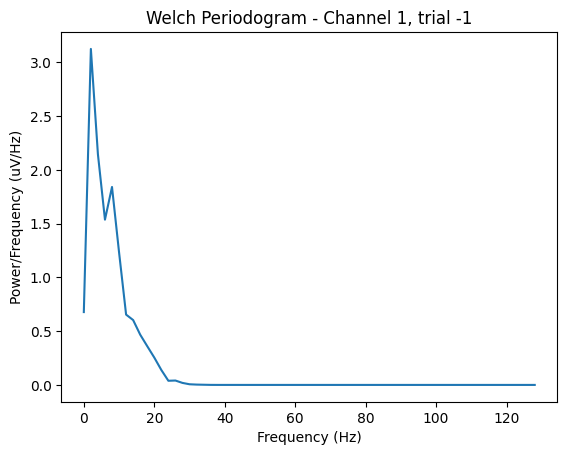

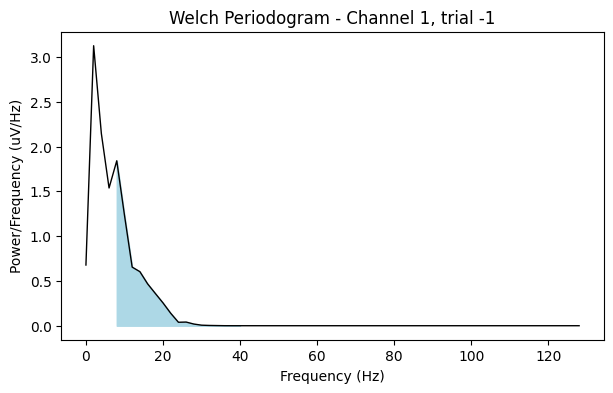

Absolute power for trial 1 and channel 1 :
9.506922634146074
(200, 87)
Ratio between alpha and beta for trial 1 and channel 1 :
12.444856903755738
(200, 87)
Ratio alfa over delte for trial 1 and channel 1 :
239587223.0653966
(200, 87)
Ratio beta over delte for trial 1 and channel 1 :
19251906.624421813
(200, 87)
Mean alpha for trial 1 and channel 1 :
0.25432419015296354
(200, 87)
Mean beta for trial 1 and channel 1 :
0.020436087945391396
(200, 87)
Variance alpha for trial 1 and channel 1 :
0.04556176329719598
(200, 87)
Variance beta for trial 1 and channel 1 :
0.00041763360390324045
(200, 87)


In [41]:
#Applying the Welch's peridiogram 
N = X_windowed.shape[2]
print(N)
nperseg = N // 5
f, Pxx = welch(X_windowed,fs, nperseg=nperseg) 

method = 'Welch'
# Change according to the pretended channel 
plot_periodogram(method, trial_index, selected_channel_index,f, Pxx)

# Finding intersecting values in frequency vector
idx = np.logical_and(f >= low, f <= high)
Pxx_channel = Pxx[trial_index, selected_channel_index,:]

plot_periodogram_bluearea(f, Pxx_channel,idx,selected_channel_index,trial_index,'Welch')

# Frequency resolution
f_res = f[1] - f[0] 

#Absolute power computation
absolute_power_welch = compute_absolute_power(Pxx, idx, f_res)
print('Absolute power for trial ' + str (trial_index+1)+ ' and channel '+ str(selected_channel_index+1) +' :' )
print(absolute_power_welch[trial_index, selected_channel_index])
print(absolute_power_welch.shape)

#ratios between absolute powers of certain frequency bands
alpha_beta_ratio_welch = compute_alpha_beta_ratio(Pxx, alpha_band, beta_band, f_res)
print('Ratio between alpha and beta for trial ' + str (trial_index+1)+ ' and channel '+ str(selected_channel_index+1) +' :' )
print(alpha_beta_ratio_welch[trial_index, selected_channel_index])
print(alpha_beta_ratio_welch.shape)

alfa_delta_ratio = compute_alpha_delta_ratio(Pxx, alpha_band, delta_band, f_res)
print('Ratio alfa over delte for trial ' + str (trial_index+1)+ ' and channel '+ str(selected_channel_index+1) +' :' )
print(alfa_delta_ratio[trial_index, selected_channel_index])
print(alfa_delta_ratio.shape)

beta_delta_ratio = compute_beta_delta_ratio(Pxx, beta_band, delta_band, f_res)
print('Ratio beta over delte for trial ' + str (trial_index+1)+ ' and channel '+ str(selected_channel_index+1) +' :' )
print(beta_delta_ratio[trial_index, selected_channel_index])
print(beta_delta_ratio.shape)

#compute mean of a certain frequency range
mean_alpha_welch = compute_mean(Pxx, alpha_band)
print('Mean alpha for trial ' + str (trial_index+1)+ ' and channel '+ str(selected_channel_index+1) +' :' )
print(mean_alpha_welch[trial_index, selected_channel_index])
print(mean_alpha_welch.shape)

mean_beta_welch = compute_mean(Pxx, beta_band)
print('Mean beta for trial ' + str (trial_index+1)+ ' and channel '+ str(selected_channel_index+1) +' :' )
print(mean_beta_welch[trial_index, selected_channel_index])
print(mean_beta_welch.shape)

#compute variance within a certain frequency range
variance_alpha_welch = compute_variance(Pxx, alpha_band)
print('Variance alpha for trial ' + str (trial_index+1)+ ' and channel '+ str(selected_channel_index+1) +' :' )
print(variance_alpha_welch[trial_index, selected_channel_index])
print(variance_alpha_welch.shape)

variance_beta_welch = compute_variance(Pxx, beta_band)
print('Variance beta for trial ' + str (trial_index+1)+ ' and channel '+ str(selected_channel_index+1) +' :' )
print(variance_beta_welch[trial_index, selected_channel_index])
print(variance_beta_welch.shape)


We have in hands a multiclassification problem. 
- **SVM** : support vector machine is a supervised method that tries to compute an hyperplane that better separate the classes, by maximizing the distance between each class in an N-dimensional space. We can have both linear or nonlinear SVM, depending on the type of data that we are facing.  

- **Linear discriminant analysis**: supervised method used for multi-class classficications problems. It seprates classes through with multiple features through data dimensionality reduction. It is driven by the following criteria: maximizing the distance between the means of two classes and by minimizing the variance within individual classes.  

- **KNN**: non-parametric, supervised learning classifier, which uses the proximity to make classifications or predictions about the grouping of an individual data point. 


Split dataset

In [78]:
#division of the data set in training set and test set
# we splitted our data into 80% training and 20% test

#considering the absolute power from welch's as feature
#x_train, x_test, y_train, y_test = train_test_split(absolute_power_welch, trial_labels, test_size=0.2, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(alpha_beta_ratio_welch, trial_labels, test_size=0.2, shuffle=False)
#x_train, x_test, y_train, y_test = train_test_split(mean_alpha_welch , trial_labels, test_size=0.2, shuffle=False)
#x_train, x_test, y_train, y_test = train_test_split(mean_beta_welch, trial_labels, test_size=0.2, shuffle=False)
#x_train, x_test, y_train, y_test = train_test_split(variance_alpha_welch, trial_labels, test_size=0.2, shuffle=False)
#x_train, x_test, y_train, y_test = train_test_split(variance_beta_welch , trial_labels, test_size=0.2, shuffle=False)
#x_train, x_test, y_train, y_test = train_test_split(alfa_beta_delta_ratio , trial_labels, test_size=0.2, shuffle =False)
#x_train, x_test, y_train, y_test = train_test_split(alfa_delta_ratio , trial_labels, test_size=0.2, shuffle =False)
#x_train, x_test, y_train, y_test = train_test_split(beta_delta_ratio , trial_labels, test_size=0.2, shuffle =False)


**SVM**

In [79]:
# hyperparameter to be tested
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4]
}

#SVM
svm = SVC()

# GridSearchCV with cross validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate with cross valiadation the best model 
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5)

print("Cross validation accurancies:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

# Evaluation on the test set 
y_pred_test = grid_search.best_estimator_.predict(x_test)

# Print classification report 
print("Classification report regarding the test set:")
print(classification_report(y_test, y_pred_test))

model = grid_search.best_estimator_

# save model with joblib 
filename = 'selectedmodel.sav'
joblib.dump(model, filename)

with open('metrics_models.txt', 'a') as file:
    # Escrever os valores no arquivo
    file.write("Support Vector Machine \n")
    file.write("cross validation accuracies SVM: "+str(cv_scores)+"\n")
    file.write("mean cross validation SVM: "+str(cv_scores.mean())+"\n")
    file.write("Classification report SVM : \n" +str(classification_report(y_test, y_pred_test))+"\n")
    


Best hyperparameters: {'C': 10, 'degree': 1, 'kernel': 'rbf'}
Cross validation accurancies: [0.25    0.34375 0.25    0.28125 0.3125 ]
Mean accuracy: 0.2875
Classification report regarding the test set:
              precision    recall  f1-score   support

        down       0.57      0.40      0.47        10
        left       0.35      0.70      0.47        10
       right       0.40      0.20      0.27        10
          up       0.50      0.40      0.44        10

    accuracy                           0.42        40
   macro avg       0.46      0.43      0.41        40
weighted avg       0.46      0.42      0.41        40



**Linear Discriminant Analysis**

In [80]:
# hyperparameter to be tested
param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [None, 'auto']
}

# LDA
lda = LinearDiscriminantAnalysis()

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate training set with cross validation
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5)

print("Cross validation accurancies:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

# Evaluation on the test set
y_pred_test = grid_search.best_estimator_.predict(x_test)

# Print classification report
print("Classification report regarding the test set:")
print(classification_report(y_test, y_pred_test))

# model = grid_search.best_estimator_

# # save model with joblib 
# filename = 'selectedmodel.sav'
# joblib.dump(model, filename)

with open('metrics_models.txt', 'a') as file:
    # Escrever os valores no arquivo
    file.write("Linear Discrimminant Analysis:\n")
    file.write("cross validation accuracies LDA: "+str(cv_scores)+"\n")
    file.write("mean cross validation LDA: "+str(cv_scores.mean())+"\n")
    file.write("Classification report LDA: \n" +str(classification_report(y_test, y_pred_test))+"\n")
   

Best Parameters: {'shrinkage': 'auto', 'solver': 'lsqr'}
Cross validation accurancies: [0.25    0.25    0.21875 0.15625 0.28125]
Mean accuracy: 0.23125
Classification report regarding the test set:
              precision    recall  f1-score   support

        down       0.22      0.20      0.21        10
        left       0.24      0.50      0.32        10
       right       0.40      0.20      0.27        10
          up       0.20      0.10      0.13        10

    accuracy                           0.25        40
   macro avg       0.27      0.25      0.23        40
weighted avg       0.27      0.25      0.23        40



**KNN**

In [81]:
# hyperparameter to be tested
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# kNN 
knn = KNeighborsClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

#  Evaluate with cross validation on training set
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5)

print("Cross validation accurancies:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

# Evaluation on the test set
y_pred_test = grid_search.best_estimator_.predict(x_test)

# Classification report
print("Classification report regarding the test set:")
print(classification_report(y_test, y_pred_test))

# model = grid_search.best_estimator_

# # save model with joblib 
# filename = 'selectedmodel.sav'
# joblib.dump(model, filename)

with open('metrics_models.txt', 'a') as file:
    # Escrever os valores no arquivo
    file.write("K-nearest neighbours: \n")
    file.write("cross validation accuracies KNN: "+str(cv_scores)+"\n")
    file.write("mean cross validation KNN: "+str(cv_scores.mean())+"\n")
    file.write("Classification report KNN: \n" +str(classification_report(y_test, y_pred_test))+"\n")
   

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}
Cross validation accurancies: [0.3125 0.375  0.375  0.375  0.3125]
Mean accuracy: 0.35
Classification report regarding the test set:
              precision    recall  f1-score   support

        down       0.15      0.20      0.17        10
        left       0.43      0.60      0.50        10
       right       0.20      0.10      0.13        10
          up       0.50      0.40      0.44        10

    accuracy                           0.33        40
   macro avg       0.32      0.33      0.31        40
weighted avg       0.32      0.33      0.31        40

